In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

class CTTransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), d=9,
                 sigma_color=75, sigma_space=50):
        # CLAHE parameters
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

        # Bilateral filter parameters
        self.d = d
        self.sigma_color = sigma_color
        self.sigma_space = sigma_space

    def __call__(self, img):


        # Convert to grayscale if needed
        if len(img.shape) > 2 and img.shape[2] > 1:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply CLAHE
        img_clahe = self.clahe.apply(img)

        # Apply Bilateral Filter
        img_filtered = cv2.bilateralFilter(img_clahe, d=self.d,
                                         sigmaColor=self.sigma_color,
                                         sigmaSpace=self.sigma_space)

        return img_filtered


def load_data(main_dir):
    images = []
    labels = []

    transform = CTTransform()

def load_data(normal_dir, cancer_dir, limit_per_class=(3000, 2500)):
    images = []
    labels = []

    transform = CTTransform()

    # Load normal images
    normal_files = [f for f in os.listdir(normal_dir) if f.endswith('.jpg')]
    normal_files = normal_files[:limit_per_class[0]]

    for filename in tqdm(normal_files, desc="Loading Normal Images"):
        image_path = os.path.join(normal_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # aplying a CLAHE to image
        image = transform(image)

        images.append(image)
        labels.append(0)

    # Load cancer images
    cancer_files = [f for f in os.listdir(cancer_dir) if f.endswith('.jpg')]
    cancer_files = cancer_files[:limit_per_class[1]]

    for filename in tqdm(cancer_files, desc="Loading Cancer Images"):
        image_path = os.path.join(cancer_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = transform(image)

        images.append(image)
        labels.append(1)

    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [3]:
image_dir = '/content/drive/MyDrive/dissertação/data/original_splited/classification/normal'
mask_dir = '/content/drive/MyDrive/dissertação/data/original_splited/classification/pancreas'

# print(len(os.listdir(image_dir)))
# print(len(os.listdir(mask_dir)))

images, labels = load_data(image_dir, mask_dir, limit_per_class=(1000, 800))

Loading Cancer Images: 100%|██████████| 800/800 [00:37<00:00, 21.59it/s]


In [4]:
import matplotlib.pyplot as plt

def plot_class_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)

    plt.bar(unique, counts, tick_label=['Normal', 'Cancer'])
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

def plot_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(images), num_samples * num_samples, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(num_samples, num_samples, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title('Com pâncreas' if labels[idx] == 1 else 'Sem pâncreas')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_image_shape_statistics(images):
    image_shapes = [image.shape for image in images]
    heights, widths = zip(*image_shapes)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(heights, bins=20, color='blue', alpha=0.7)
    plt.title('Image Height Distribution')
    plt.xlabel('Height')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=20, color='green', alpha=0.7)
    plt.title('Image Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


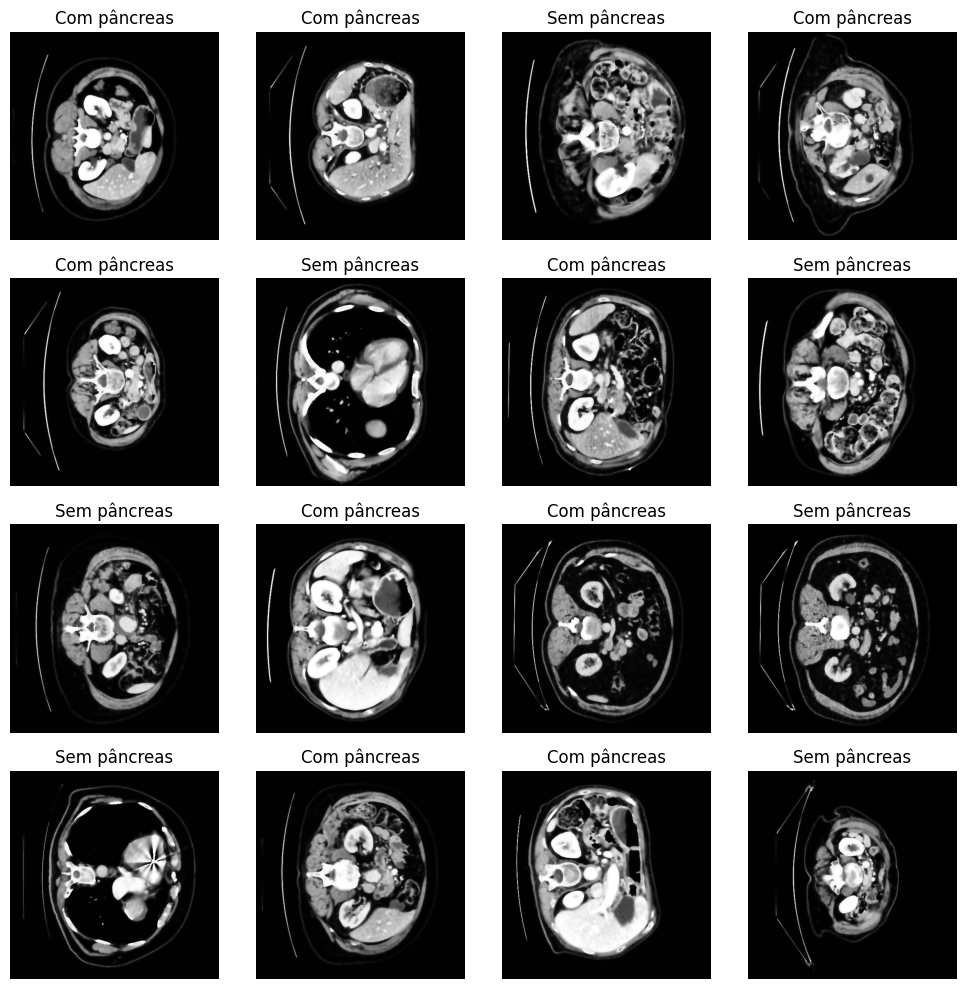

In [5]:
plot_sample_images(images, labels, num_samples=4)

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

class CustomResNetModel(nn.Module):
    def __init__(self, input_shape=(1, 224, 224), num_classes=1):
        super(CustomResNetModel, self).__init__()

        # Load the pre-trained ResNet50 model
        self.base_model = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Modify the first convolutional layer to accept single-channel input
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify the classifier (fully connected layer) of the ResNet50 model
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Use sigmoid for binary classification
        )

    def forward(self, x):
        x = self.base_model(x)
        return x


class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [14]:
import torch
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix
from tqdm import tqdm

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    criterion.to(device)

    # Store metrics for each epoch
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'sensitivity': [],  # Sensitivity (Recall)
        'precision': [],
        'f1_score': [],
        'specificity': [],   # Specificity
        'confusion_matrix': []  # Confusion matrix
    }

    print("-----------------------------------")

    best_recall = 0.0
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Training phase with tqdm for loss tracking
        train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", leave=False)
        for images, labels in train_loader_tqdm:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images).view(-1, 1)  # Ensure outputs have shape [batch_size, 1]
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Update tqdm with current loss
            avg_train_loss = running_loss / len(train_loader)
            train_loader_tqdm.set_postfix({'Train Loss': avg_train_loss})

        print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        all_labels = []
        all_preds = []

        val_loader_tqdm = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", leave=False)
        with torch.no_grad():
            for images, labels in val_loader_tqdm:
                images = images.to(device)
                labels = labels.to(device).float().view(-1, 1)  # Ensure labels have shape [batch_size, 1]

                outputs = model(images).view(-1, 1)  # Ensure outputs have shape [batch_size, 1]
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Convert logits to binary predictions
                predicted = (outputs >= 0.5).float()

                # Move tensors to CPU for numpy operations
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

            # Calculate validation metrics
            avg_val_loss = val_loss / len(val_loader)

            # Sensitivity is recall
            sensitivity = recall_score(all_labels, all_preds, zero_division=1)
            precision = precision_score(all_labels, all_preds, zero_division=1)
            f1 = f1_score(all_labels, all_preds, zero_division=1)

            # Confusion matrix to calculate specificity
            tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
            specificity = tn / (tn + fp)

            if best_recall < specificity:
                best_recall = specificity
                torch.save(model.state_dict(), "/content/drive/MyDrive/dissertação/filter_data.pth")
                print("Model saved!")


            # Confusion matrix itself
            cm = confusion_matrix(all_labels, all_preds)

            # Update tqdm with validation metrics
            val_loader_tqdm.set_postfix({
                'Val Loss': avg_val_loss,
                'Sensitivity': sensitivity,
                'Precision': precision,
                'F1 Score': f1,
                'Specificity': specificity
            })

        # Store metrics and confusion matrix
        metrics['train_loss'].append(avg_train_loss)
        metrics['val_loss'].append(avg_val_loss)
        metrics['sensitivity'].append(sensitivity)
        metrics['precision'].append(precision)
        metrics['f1_score'].append(f1)
        metrics['specificity'].append(specificity)
        metrics['confusion_matrix'].append(cm)  # Store confusion matrix for each epoch

        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Sensitivity: {sensitivity:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Confusion Matrix:\n{cm}")

        print("-----------------------------------\n")

    return metrics

In [15]:
import torch
import random
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import statistics
import torch.optim as optim

# Assuming the CustomResNetModel and CustomImageDataset are defined elsewhere
input_shape = (1, 512, 512)  # Standard input size for VGG16

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((input_shape[1], input_shape[2])),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Slightly alter brightness and contrast
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize to have mean 0 and std 1 (adjust as needed for your dataset)
])

num_runs = 1
epochs = 10
learning_rate = 0.0001
batch_size = 16

model = CustomResNetModel(input_shape=input_shape, num_classes=1)

# Define loss function with class weights
criterion = nn.BCELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Storaging the results of each run in holdout
all_results = []

# Start the Hold-out
for run in range(num_runs):
    print(f"\nRun {run+1}/{num_runs}")

    # Set random seed for reproducibility
    random_seed = random.randint(1, 100)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    # Split data into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=0.2, random_state=random_seed
    )

    # Create datasets
    train_dataset = CustomImageDataset(train_images, train_labels, transform=transform)
    val_dataset = CustomImageDataset(val_images, val_labels, transform=transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Train and evaluate the model
    metrics = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=epochs)
    all_results.append(metrics)



Run 1/1
-----------------------------------


Epoch [1/10] Training Loss: 0.4821


Model saved!
Validation Loss: 0.3112
Sensitivity: 0.8553
Precision: 0.8725
F1 Score: 0.8638
Specificity: 0.9087
Confusion Matrix:
[[189  19]
 [ 22 130]]
-----------------------------------



Epoch [2/10] Training Loss: 0.2163


Validation Loss: 0.2896
Sensitivity: 0.9211
Precision: 0.7955
F1 Score: 0.8537
Specificity: 0.8269
Confusion Matrix:
[[172  36]
 [ 12 140]]
-----------------------------------



Epoch [3/10] Training Loss: 0.1625


Validation Loss: 0.2009
Sensitivity: 0.9539
Precision: 0.8788
F1 Score: 0.9148
Specificity: 0.9038
Confusion Matrix:
[[188  20]
 [  7 145]]
-----------------------------------



Epoch [4/10] Training Loss: 0.1258


Model saved!
Validation Loss: 0.1604
Sensitivity: 0.9737
Precision: 0.9308
F1 Score: 0.9518
Specificity: 0.9471
Confusion Matrix:
[[197  11]
 [  4 148]]
-----------------------------------



Epoch [5/10] Training Loss: 0.1231


Model saved!
Validation Loss: 0.0997
Sensitivity: 0.9474
Precision: 0.9796
F1 Score: 0.9632
Specificity: 0.9856
Confusion Matrix:
[[205   3]
 [  8 144]]
-----------------------------------



Epoch [6/10] Training Loss: 0.0781


Validation Loss: 0.1475
Sensitivity: 0.9211
Precision: 0.9722
F1 Score: 0.9459
Specificity: 0.9808
Confusion Matrix:
[[204   4]
 [ 12 140]]
-----------------------------------



Epoch [7/10] Training Loss: 0.0798


Validation Loss: 0.1067
Sensitivity: 0.9474
Precision: 0.9664
F1 Score: 0.9568
Specificity: 0.9760
Confusion Matrix:
[[203   5]
 [  8 144]]
-----------------------------------



Epoch [8/10] Training Loss: 0.0850


Validation Loss: 0.1013
Sensitivity: 0.9934
Precision: 0.9437
F1 Score: 0.9679
Specificity: 0.9567
Confusion Matrix:
[[199   9]
 [  1 151]]
-----------------------------------



Epoch [9/10] Training Loss: 0.0554


Validation Loss: 0.0853
Sensitivity: 0.9539
Precision: 0.9732
F1 Score: 0.9635
Specificity: 0.9808
Confusion Matrix:
[[204   4]
 [  7 145]]
-----------------------------------



Epoch [10/10] Training Loss: 0.0492


Validation Loss: 0.0581
Sensitivity: 1.0000
Precision: 0.9744
F1 Score: 0.9870
Specificity: 0.9808
Confusion Matrix:
[[204   4]
 [  0 152]]
-----------------------------------



In [16]:
import numpy as np

def summarize_metrics(metrics):
    # Calculate mean values for each metric
    mean_train_loss = np.mean(metrics['train_loss'])
    mean_val_loss = np.mean(metrics['val_loss'])
    mean_sensitivity = np.mean(metrics['sensitivity'])
    mean_precision = np.mean(metrics['precision'])
    mean_f1_score = np.mean(metrics['f1_score'])
    mean_specificity = np.mean(metrics['specificity'])

    # Find the best (max) values for each metric
    best_epoch = np.argmin(metrics['val_loss'])  # Best epoch is the one with lowest validation loss
    best_val_loss = metrics['val_loss'][best_epoch]
    best_sensitivity = metrics['sensitivity'][best_epoch]
    best_precision = metrics['precision'][best_epoch]
    best_f1_score = metrics['f1_score'][best_epoch]
    best_specificity = metrics['specificity'][best_epoch]

    # Print the confusion matrix of the best epoch
    best_confusion_matrix = metrics['confusion_matrix'][best_epoch]

    print("----- Metric Summary -----")
    print(f"Mean Training Loss: {mean_train_loss:.4f}")
    print(f"Mean Validation Loss: {mean_val_loss:.4f}")
    print(f"Mean Sensitivity (Recall): {mean_sensitivity:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean F1 Score: {mean_f1_score:.4f}")
    print(f"Mean Specificity: {mean_specificity:.4f}")

    print("\n----- Best Metrics (Epoch {}) -----".format(best_epoch+1))
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Best Sensitivity (Recall): {best_sensitivity:.4f}")
    print(f"Best Precision: {best_precision:.4f}")
    print(f"Best F1 Score: {best_f1_score:.4f}")
    print(f"Best Specificity: {best_specificity:.4f}")

    print("\nConfusion Matrix for Best Epoch:")
    print(best_confusion_matrix)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_training_metrics(metrics):
    """
    Plot training metrics and confusion matrix.

    Args:
        metrics (dict): Dictionary containing training metrics like 'train_loss', 'val_loss',
                        'sensitivity', 'precision', 'f1_score', 'specificity', and 'confusion_matrix'.
    """
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot sensitivity
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics['sensitivity'], label='Sensitivity', color='b')
    plt.title('Sensitivity')
    plt.xlabel('Epochs')
    plt.ylabel('Sensitivity')

    # Plot precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics['precision'], label='Precision', color='g')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')

    # Plot F1 score and specificity
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics['f1_score'], label='F1 Score', color='r')
    plt.plot(epochs, metrics['specificity'], label='Specificity', color='m')
    plt.title('F1 Score and Specificity')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    """
    Plot the confusion matrix.

    Args:
        cm (np.array): The confusion matrix to plot.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



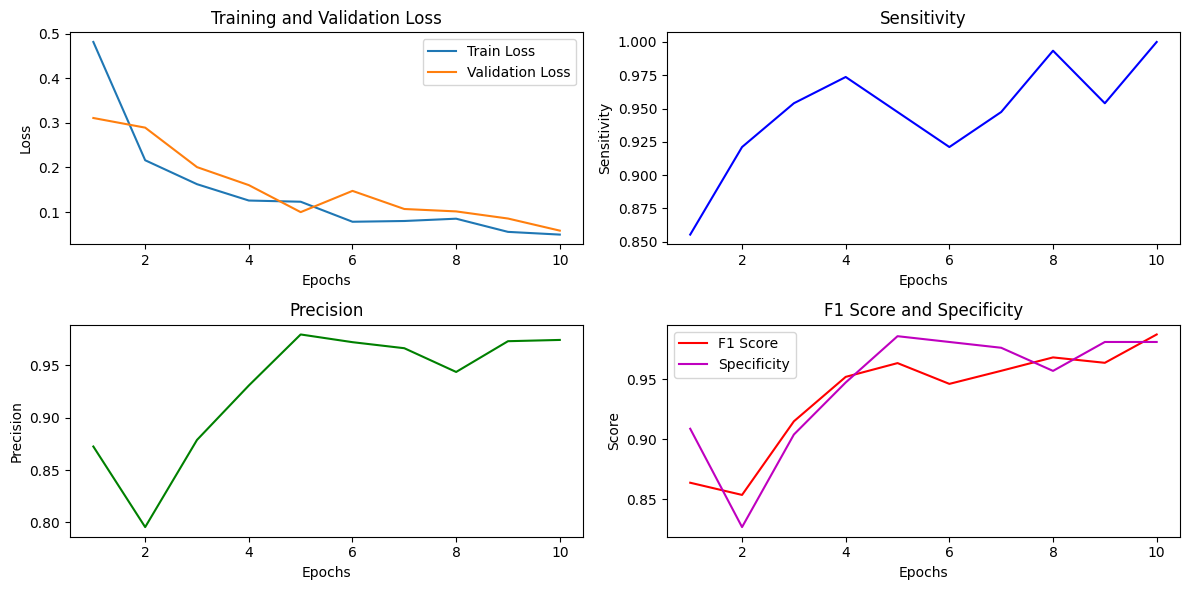

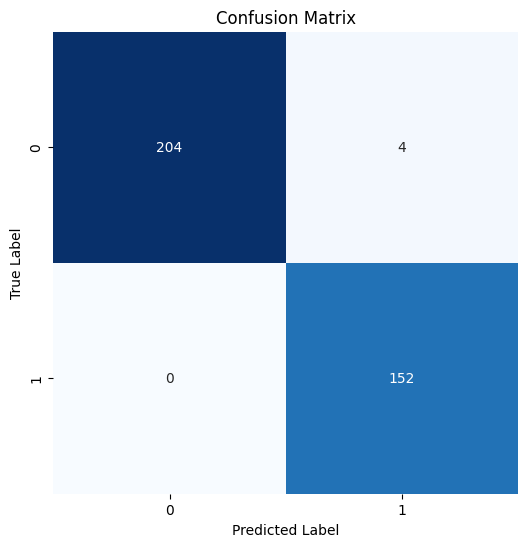

In [18]:
# Example usage:
# Assuming `metrics` dictionary is populated with training values for each epoch
# metrics = train_model(...)  # This will return the metrics dictionary
plot_training_metrics(metrics)

# Plot the confusion matrix for the last epoch
last_cm = metrics['confusion_matrix'][-1]
plot_confusion_matrix(last_cm)